Almost all the error comes from the CNOT gates. Lets investigate whether this varies with beta

In [21]:
import pandas as pd

## Hardware

In [22]:
run_on_hardware = False

### Set up server

In [23]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import Parameter

# Make the circuit
# Can initialise it all now and pass in a parameter 
def make_circuit(gamma):
    qc = QuantumCircuit(2)
    # gamma = Parameter("angle")
    # some hadamard gates first to ensure entanglement
    qc.h(0)
    qc.h(1)
    qc.rzz(2 * gamma, 0, 1)  # Virtual Rz(2γ)
    qc.metadata = {"gamma": gamma}  # Store gamma value
    qc.measure_all()
    return qc

# details to allow it to run later
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")

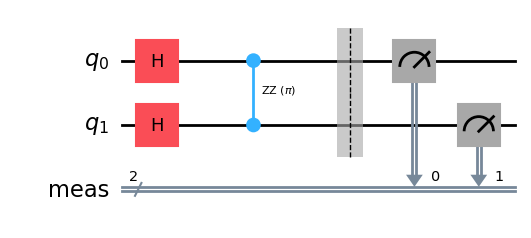

In [24]:
circ = make_circuit(gamma=np.pi/2)
circ.draw("mpl")

### submit to run on ibm hardware

In [25]:
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
# pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)
from qiskit_ibm_runtime import Batch
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
backend = service.backend("ibm_brisbane")
pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Define rotation angles to test
gamma_values = np.pi*np.linspace(0, 1, 20)  # Test 50 angles between 0 and π

# some parameters
repeat_num = 1
shots = 2**15
poss_outcomes = ["00", "01", "10", "11"]
name_per_outc = ["gamma"] + [f"rep{rep_num}" for rep_num in range(repeat_num)]
isa_all = []
count = 0
if run_on_hardware:
    with Batch(backend=backend) as batch:
        sampler = Sampler(mode=batch) #Sampler(mode=simulator)
        for repeats in range(repeat_num):
            error_rates = []
            for gamma_val in gamma_values:
                count += 1
                # noise
                # qc.assign_parameters({gamma: gamma_val})
                qc = make_circuit(gamma=gamma_val)
                isa_qc = pm_noisy.run(qc)
                isa_all.append(isa_qc)

        job = sampler.run(isa_all, shots=shots)